In [221]:
# preprocessing images

import os, random, cv2
import numpy as np
import imutils.paths as paths
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from torch import nn
import torch.optim as optim
import time


In [245]:
%config Completer.use_jedi = False



In [229]:
%%bash 
pip3 install tensorboard


In [2]:
num_images = 1200

In [3]:
dir_paths = os.listdir('./Train')
dir_paths.sort()
print(dir_paths)

root_path = './Train'

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [4]:
from tqdm import tqdm


for idx, dir_path in tqdm(enumerate(dir_paths), total=len(dir_paths)):
    all_images = os.listdir(f'{root_path}/{dir_path}')
    os.makedirs(f"./preprocessed_image/{dir_path}", exist_ok=True)
    for i in range(num_images):
        rand_id = random.randint(0, 2999)
        image = cv2.imread(f'{root_path}/{dir_path}/{all_images[rand_id]}')
        image = cv2.resize(image, (244, 244))
        cv2.imwrite(f"./preprocessed_image/{dir_path}/{dir_path}{i}.jpg", image)

100%|██████████| 29/29 [01:44<00:00,  3.60s/it]


In [68]:
# building data.csv containing image_paths and its labels

image_paths = list(paths.list_images('./Train'))
# print(image_paths)
data = pd.DataFrame()

labels = []

for i, image_path in tqdm(enumerate(image_paths), total =len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    data.loc[i, 'image_path'] = image_path
    
    labels.append(label)

labels = np.array(labels)

from sklearn.preprocessing import LabelBinarizer


# Mapping the first one hot encoded label to its category
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)

data = data.sample(frac=1).reset_index(drop=True)
# data.to_csv('../input/data.csv', index=False)



    

100%|██████████| 87000/87000 [03:42<00:00, 391.46it/s] 


In [69]:
data.head()

,image_path,target
0,./Train/O/O2592.jpg,14.0
1,./Train/X/X2852.jpg,23.0
2,./Train/space/space2387.jpg,28.0
3,./Train/B/B2914.jpg,1.0
4,./Train/A/A701.jpg,0.0


In [70]:
data.target.nunique()

29

In [130]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



train_set, test_set = train_test_split(data, test_size=0.2,random_state=42)
train_set.to_csv('./train_set.csv', index=False)
test_set.to_csv('./test_set.csv', index=False)

In [131]:
df_train = pd.DataFrame(train_set.target.value_counts()).reset_index()
df_train.columns = ['Class', 'Samples']
# df_train.Samples = (df_train.Samples - df_train.Samples.min()) / (df_train.Samples.max() - df_train.Samples.min())
df_train.head()

,Class,Samples
0,12.0,2449
1,18.0,2440
2,23.0,2440
3,21.0,2425
4,0.0,2411


### Plot of distribution(train and test)

/home/nayugartx8/Desktop/Aayush_work/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='Samples'>

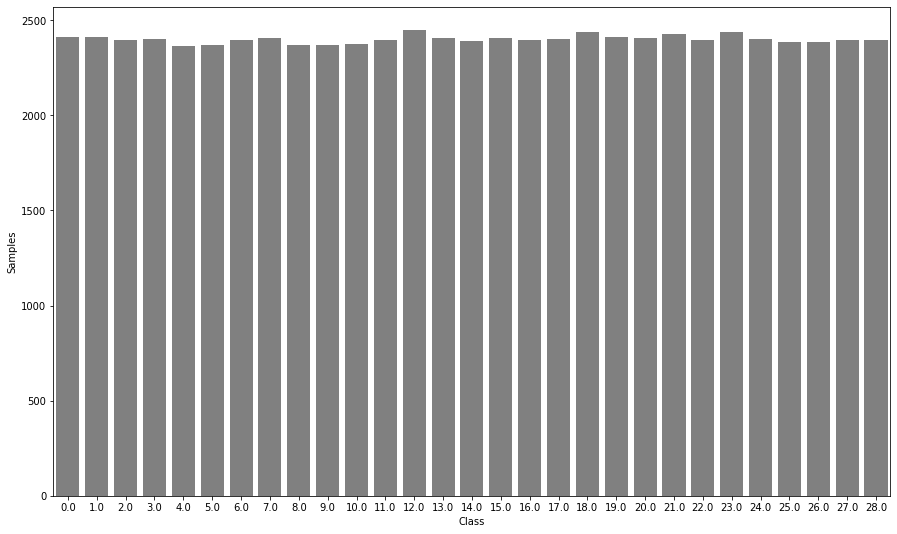

In [132]:
import seaborn as sns

plt.figure(figsize=(15, 9))
sns.barplot(df_train.Class, df_train.Samples, color='gray')



In [133]:
df_test = pd.DataFrame(test_set.target.value_counts()).reset_index()
df_test.columns = ['Class', 'Samples']
# df_test.Samples = (df_test.Samples - df_test.Samples.min()) / (df_test.Samples.max() - df_test.Samples.min())
df_test.head()

,Class,Samples
0,4.0,635
1,9.0,632
2,8.0,630
3,5.0,628
4,10.0,624


/home/nayugartx8/Desktop/Aayush_work/work/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Class', ylabel='Samples'>

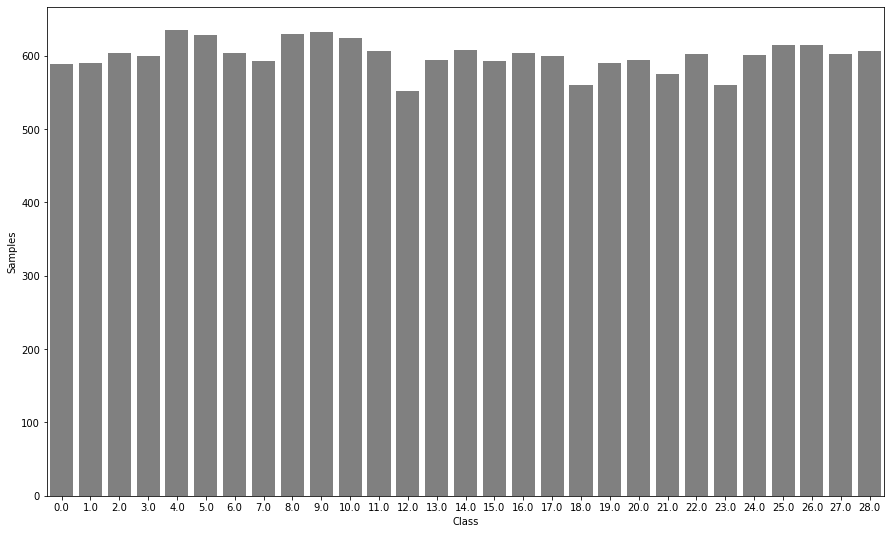

In [134]:
plt.figure(figsize=(15, 9))
sns.barplot(df_test.Class, df_test.Samples, color='gray')

In [135]:
data.to_csv('./data.csv', index=False)

In [399]:
len(data)

2

In [415]:
class ASL_dataset(Dataset):
    
    def __init__(self, csv_path, train=True):

        self.csv_file = pd.read_csv(csv_path)
        self.train = train
        if self.train:
            self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        else:
            self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
            ])
        
    def __len__(self):
        return len(self.csv_file)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.to_list()
        image_name = os.path.join(self.csv_file.iloc[idx, 0])
#         print(image_name)
        image = Image.open(image_name)
        
        labels = np.array(self.csv_file.iloc[idx, 1:]).astype(np.float32)
#         print(labels)
        sample = {'image': image, 'labels': labels }
        sample['image'] = self.transform(sample['image'])
        sample['labels'] = torch.tensor(int(sample['labels'])).long()
        return sample
            
        


### Plot some random samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224]) torch.Size([])
1 torch.Size([3, 224, 224]) torch.Size([])
2 torch.Size([3, 224, 224]) torch.Size([])
3 torch.Size([3, 224, 224]) torch.Size([])


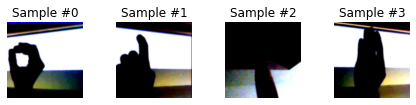

In [416]:
asl_dataset = ASL_dataset(csv_path='./data.csv')
# print(len(asl_dataset))
import matplotlib.pyplot as plt
for i in range(len(asl_dataset)):
    sample = asl_dataset[i]
    print(i, sample['image'].shape, sample['labels'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(np.transpose(sample['image'].numpy(), (1, 2, 0)), interpolation='gaussian')

    if i == 3:
        plt.show()
        break

###  Model Creation

In [417]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [418]:
# Defining model



class SignLanguageClassifier(nn.Module):
    
    def __init__(self):
        super(SignLanguageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 3)
        
        self.fc1 = nn.Linear(128, 96)
        self.fc2 = nn.Linear(96, 64)
        self.fc3 = nn.Linear(64,len(lb.classes_))
        
        self.drop = nn.Dropout(0.25)
        
#         self.bn1 = nn.BatchNorm2d(3, 16, 3)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self, x):
        # conv1
        x = self.conv1(x)
        x = self.pool(nn.functional.relu(x))
        
    
        # conv2
        x =self.conv2(x)
        x = self.bn2(x)
        x = self.pool(nn.functional.relu(x))
        #conv3
        x = self.bn3(self.conv3(x))
        x = self.pool(nn.functional.relu(x))
        #conv4 
        x = self.bn4(self.conv4(x))
        x = self.pool(nn.functional.relu(x))
        
        #fully connected layers
        batch_size, _, _, _ = x.shape
        
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        x = self.drop(nn.functional.relu(self.fc1(x)))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

### Training Code

In [419]:
# setting params
epochs = 100

# seeds
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.benchmark=True

In [420]:
train_data = ASL_dataset('./train_set.csv')
test_data = ASL_dataset('./test_set.csv', train=False)

In [421]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [422]:
model = SignLanguageClassifier().to(device)
print(model)

SignLanguageClassifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=29, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [423]:
model.forward(torch.zeros((1, 3, 256, 256)).to(device))

tensor([[-0.0404,  0.0955, -0.0230, -0.0319,  0.1357,  0.0122, -0.0119,  0.0386,
         -0.0904, -0.0250, -0.1059,  0.0076,  0.0648,  0.0277, -0.1195, -0.0690,
         -0.0257,  0.0604, -0.1313,  0.1385,  0.1024,  0.0028, -0.0897, -0.0666,
         -0.0087, -0.1171, -0.0341, -0.1289,  0.1199]], device='cuda:0',
       grad_fn=<AddmmBackward>)

In [424]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
         MaxPool2d-2         [-1, 16, 127, 127]               0
            Conv2d-3         [-1, 32, 123, 123]          12,832
       BatchNorm2d-4         [-1, 32, 123, 123]              64
         MaxPool2d-5           [-1, 32, 61, 61]               0
            Conv2d-6           [-1, 64, 57, 57]          51,264
       BatchNorm2d-7           [-1, 64, 57, 57]             128
         MaxPool2d-8           [-1, 64, 28, 28]               0
            Conv2d-9          [-1, 128, 26, 26]          73,856
      BatchNorm2d-10          [-1, 128, 26, 26]             256
        MaxPool2d-11          [-1, 128, 13, 13]               0
           Linear-12                   [-1, 96]          12,384
          Dropout-13                   [-1, 96]               0
           Linear-14                   

In [425]:
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

159,325 total parameters.
159,325 training parameters.


In [426]:
# Optimizer 
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [427]:
# checkpoints

checkpoint_file_path = './checkpoint.ckpt'
best_checkpoint = './best_checkpoint.ckpt'

 torch.save({\
                   'epoch': epoch,
                   'model_state_dict' : model.state_dict(),
                   'optimizer_state_dict' : optimizer.state_dict(),
                   'validation_accuracy' : validation_accuracy,
                    "best_accuracy" : best_accuracy
                   }, CHECKPOINT_FILE 


In [442]:
# model training

for epoch in range(10):  # loop over the dataset multiple times
       
    train_loss = 0.0
   
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total = len(train_loader), desc = "Training"):
     
        inputs, labels = data['image'].to(device), data['labels'].to(device)
        optimizer.zero_grad() # gradient set to zero
     
        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        train_loss+= loss.item()
        loss.backward()
        optimizer.step()
      
        

        # print statistics
        running_loss += loss.item()

print('Finished Training')

0it [02:32, ?it/s]       | 2/2175 [00:00<05:38,  6.41it/s]
0it [02:32, ?it/s]
Training: 100%|██████████| 2175/2175 [03:39<00:00,  9.92it/s]

Finished Training


In [443]:
torch.save(model, './Sign_Language_Classifier.pth')

In [444]:
# testing_net

correct = 0
total = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader, 0), total=len(test_loader), desc='Testing'):
        inputs, labels = data['image'].to(device), data['labels'].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


Testing: 100%|██████████| 544/544 [01:17<00:00,  7.06it/s]

Accuracy of the network on the test images: 39 %
